In [2]:
import pandas as pd
import numpy as np


with open('../data/Prediction.csv', 'r') as f:
    data = pd.read_csv(f)

#Transform Variables that should be ordinal to reduce categorical columns
def Convert_Ordinal(data:pd.DataFrame) -> pd.DataFrame:

    out = data.copy()

    #MSSubClass should be categorical
    mapping = {
        20:'1-STORY 1946 & NEWER ALL STYLES',
        30:'1-STORY 1945 & OLDER',
        40:'1-STORY W/FINISHED ATTIC ALL AGES',
        45:'1-1/2 STORY - UNFINISHED ALL AGES',
        50:'1-1/2 STORY FINISHED ALL AGES',
        60:'2-STORY 1946 & NEWER',
        70:'2-STORY 1945 & OLDER',
        75:'2-1/2 STORY ALL AGES',
        80:'SPLIT OR MULTI-LEVEL',
        85:'SPLIT FOYER',
        90:'DUPLEX - ALL STYLES AND AGES',
        120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
        150:'1-1/2 STORY PUD - ALL AGES',
        160:'2-STORY PUD - 1946 & NEWER',
        180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
        190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'
    }
    out['MSSubClass'] = out['MSSubClass'].replace(mapping)

    #Quality and Condition
    mapping = {
        'Ex':5,
        'Gd':4,
        'TA':3,
        'Fa':2,
        'Po':1,
        'NA':-1,
    }
    col_apply = [
        'ExterQual', 'ExterCond',
        'BsmtQual', 'BsmtCond',
        'HeatingQC',
        'KitchenQual',
        'GarageQual', 'GarageCond',
        'FireplaceQu'
    ]
    for col in col_apply: 
        out[col] = out[col].replace(mapping)
        out[col] = out[col].fillna(-1)
        out[col] = out[col].astype(int)

    #Basement Exposure
    mapping = {
        'Gd':3,
        'Av':2,
        'Mn':1,
        'No':0
    }
    out['BsmtExposure'] = out['BsmtExposure'].replace(mapping)
    out['BsmtExposure'] = out['BsmtExposure'].fillna(-1)
    out['BsmtExposure'] = out['BsmtExposure'].astype(int)

    #Deductions
    mapping = {
        'Typ':-1,
        'Min1':1,
        'Min2':2,
        'Mod':3,
        'Maj1':4,
        'Maj2':5,
        'Sev':6,
        'Sal':7
    }
    out['Functional'] = out['Functional'].replace(mapping).astype('int')

    #Garage Finsish
    mapping = {
        'Fin':1,
        'RFn':0.5,
        'Unf':0
    }
    out['GarageFinish'] = out['GarageFinish'].replace(mapping).astype('float')
    out['GarageFinish'] = out['GarageFinish'].fillna(-1)

    #PavedDrive; Penalized for non as most have one
    mapping = {
        'Y':0,
        'P':0.5,
        'N':1
    }
    out['NoPavedDrive'] = out['PavedDrive'].replace(mapping).astype(float)
    out = out.drop(columns=['PavedDrive'])

    #Fence Quality
    mapping = {
        'GdPrv':4,
        'MnPrv':3,
        'GdWo':2,
        'MnWw':1,
        'NA':-1
    } 
    out['Fence'] = out['Fence'].replace(mapping)
    out['Fence'] = out['Fence'].fillna(-1)
    out[col] = out[col].astype(int)

    return out

#Feature Engeneer variables that indicate House Features
def Noncategorical_Dummies(data:pd.DataFrame) -> pd.DataFrame:

    out = data.copy()

    out['CentralAir'] = np.where(out['CentralAir'] == 'N', 0, 1)

    out['Remodeled'] = np.where(out['YearRemodAdd'] == out['YearBuilt'], 0, 1)
    
    out['MasonryVeneer'] = np.where(out['MasVnrType'].isna(), 0, 1)
    out = out.drop(columns=['MasVnrArea', 'MasVnrType'])

    out['AlleyAccess'] = np.where(out['Alley'].isna(), 0, 1)
    out = out.drop(columns=['Alley'])

    # 'Has_' Prefix indicates var, that are both dummies but also have rankings/values attached 
    out['Has_Basement'] = np.where(out['BsmtExposure'].isna(), 0, 1)

    out['Has_Garage'] = np.where(out['GarageType'].isna(), 0, 1)

    out['Has_Deduction'] = np.where(out['Functional'] == 'Typ', 0, 1)

    out['Has_StreetAccess'] = np.where(out['LotFrontage'].isna(), 0, 1)

    out['Has_Fireplace'] = np.where(out['Fireplaces'] == 0, 0, 1)

    out['Has_Porch'] = np.where(out['OpenPorchSF'] == 0, 0, 1)

    out['Has_Deck'] = np.where(out['WoodDeckSF'] == 0, 0, 1)

    return out

#Summarise Variables into compacter formats that are more natural to how humans judge things like no. bathrooms
def Summarise_Variables(data:pd.DataFrame) -> pd.DataFrame:

    out = data.copy()

    #Convert the FinishType-Finish Square Feet Variables into Percentage Area per Finish to capture actual effect of a basement having that finish
    BsmtFinishes = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf']
    for finish in BsmtFinishes:
        if finish == 'Unf': 
            out['BsmtFinish_Unf'] = out['BsmtUnfSF'] / out['TotalBsmtSF']
            continue

        out[f'BsmtFinish_{finish}'] = np.where(out['BsmtFinType1'] == finish, out['BsmtFinSF1'] / out['TotalBsmtSF'], 0) + \
                                      np.where(out['BsmtFinType2'] == finish, out['BsmtFinSF2'] / out['TotalBsmtSF'], 0) 

    out = out.drop(columns=['BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'])


    out['BsmtBathrooms'] = out['BsmtFullBath'] + 0.5*out['BsmtHalfBath']
    out = out.drop(columns=['BsmtFullBath', 'BsmtHalfBath'])

    out['Bathrooms'] = out['FullBath'] + 0.5*out['HalfBath']
    out = out.drop(columns=['FullBath', 'HalfBath'])

    #Age relative to youngest Object
    out['Age'] = out['YearBuilt'].max() - out['YearBuilt']
    out['RemodeledAge'] = np.where(out['Remodeled'] == 1, out['YearRemodAdd'].max() - out['YearRemodAdd'], -1)
    out['GarageAge'] = out['GarageYrBlt'].max() - out['GarageYrBlt'].fillna(out['GarageYrBlt'].max() + 1) #No Garage = -1
    out = out.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])

    #Make Selldate categorical, assuming that each timeperiod has a distinct market effect on housing
    def SoldDate(month, year):
        month = str(month)
        if len(month) == 1: month = f'0{month}'
        year = str(year)
        year_month = '-'.join([month, year])
        #integrate datetime formatting?
        return year_month
        

    out['Sold'] = out.apply(lambda x: SoldDate(x['MoSold'], x['YrSold']), axis=1)
    out = out.drop(columns=['MoSold', 'YrSold'])

    return out

def Standardize_NonApplicable(data:pd.DataFrame) -> pd.DataFrame:

    out = data.copy()

    # Fill NaN with -1
    out['LotFrontage'] = out['LotFrontage'].fillna(-1)
    # -1 for all variables, where 0 indicates non-applicability
    for col in ['BsmtFinish_GLQ', 'BsmtFinish_ALQ', 'BsmtFinish_BLQ', 'BsmtFinish_Rec', 'BsmtFinish_LwQ', 'BsmtFinish_Unf',
                'TotalBsmtSF', 'BsmtBathrooms']:
        out[col] = np.where(out['Has_Basement'] == 0, -1, out[col])
    for col in ['GarageCars', 'GarageArea']:
        out[col] = np.where(out['Has_Garage'] == 0, -1, out[col])
    for col in ['2ndFlrSF', 'Fireplaces', 'MiscVal', 'WoodDeckSF', 'OpenPorchSF']: 
        out[col] = out[col].replace({0:-1})

    return out



data = Noncategorical_Dummies(data)
data = Convert_Ordinal(data)
data = Summarise_Variables(data)
data = Standardize_NonApplicable(data)

#Utilities different for only 1 property
data = data.drop(columns=['Utilities', 'Id'])

C:\Users\karli\AppData\Local\Temp\ipykernel_53740\1056039557.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[col] = out[col].replace(mapping)
C:\Users\karli\AppData\Local\Temp\ipykernel_53740\1056039557.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[col] = out[col].replace(mapping)
C:\Users\karli\AppData\Local\Temp\ipykernel_53740\1056039557.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_obje

In [3]:
import pandas as pd
import numpy as np
import pickle

def PrepX(X:pd.DataFrame):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    #Iterates over X and applies transformations based on column type; Adds transformed columns 
    new_cols = []
    for col, t in X_types.items():

        #Leaves numeric columns unchanged, no scaling needed for tree-based methods, scale invariant
        if t in ['int', 'float']: 
            new_cols.append(X[col].copy())
            continue

        #Create dummies for categorical (str) columns
        if t == 'object': 
            new_col = pd.get_dummies(X[col], prefix=col, drop_first=True, dtype=int)
            new_cols.append(new_col)
            continue

        print(f'Type \"{t}\" not in standard types!')

    if new_cols: X_prep = pd.concat([X_prep] + new_cols, axis=1)

    return X_prep


# Load Training Data to correctly identify columns
with open('../data/DatasetCleaned.csv', 'r') as f: train_data = pd.read_csv(f)
X_DATA = PrepX(train_data.copy().drop(columns=['SalePrice','Unnamed: 0']))
VAR_NAMES = X_DATA.columns

#Prediction Data
X_PREDICT = data.copy()
X_PREDICT = PrepX(X_PREDICT)

#Ensure same column order and all columns are present
TEMP = []
for col in VAR_NAMES:
    if col in X_PREDICT.columns: TEMP.append(X_PREDICT[col])
    else: TEMP.append(pd.Series(np.zeros(len(X_PREDICT)), name = col))
X_PREDICT = pd.concat(TEMP, axis=1)

X_PREDICT = X_PREDICT.values.reshape(-1,X_PREDICT.shape[1])

In [4]:
#Redefine Stacked Transformer Class prior to loading it
class StackedTransformer:
    def __init__(self, top_models):
        self.top_models = top_models

    def __call__(self, X_new):

        y_pred = pd.DataFrame(np.column_stack([model.predict(X_new) for model in self.top_models]), 
                              columns=[f'Model_{i}' for i in range(len(self.top_models))])

        return y_pred
    
#Import Model; We Import the best Performing 
import pickle

with open('Trees/models/XGBoost_StackedModel.sav', 'rb') as f: model_dict = pickle.load(f)

StackedModel = model_dict['StackedModel']
XPrepFunction = model_dict['XPrepFunction']


#Calculate Predictions
Y_PREDICTED_XGBOOST = StackedModel.predict(XPrepFunction(X_PREDICT))
Y_PREDICTED_XGBOOST = np.exp(Y_PREDICTED_XGBOOST)


Check against Lasso

In [6]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import PowerTransformer

def PrepX(X:pd.DataFrame, scaler_type=PowerTransformer(method='yeo-johnson'), 
          only_dummies:bool=False, fit:bool=False):

    X_prep = pd.DataFrame(index=X.index)
    X_types = X.dtypes.to_dict()

    #Stores Scalers later in Dictionary (Column:Scaler)
    if fit: scalers = {}
    else: scalers = scaler_type

    new_cols = []

    #Iterates over X and applies transformations based on column type; Adds transformed columns 
    for col, t in X_types.items():

        #Dummy columns and Percentages that don't need to be scaled (computed in Preperation.ipynb)
        if t != 'object' and -1 <= X[col].min() and X[col].max() <= 1 and not only_dummies: 
            new_cols.append(X[col].copy().replace({-1:0})) 
            continue

        #Transforms Numeric values; either builds scalers or applies them
        if t in ['int', 'float'] and not only_dummies:
            nonapplicable = X[col] == -1

            new_col = X[col].copy()
            applic_values = new_col.loc[~nonapplicable].values.reshape(-1, 1)

            #If fit=True, construct a new scaler for the training data. Otherwise, use the SCALER dict to scale test data
            if fit: 
                scaler = clone(scaler_type)
                scaler.fit(applic_values)
                scalers[col] = scaler
                new_col.loc[~nonapplicable] = scaler.transform(applic_values).flatten()
            else:
                new_col.loc[~nonapplicable] = scalers[col].transform(applic_values).flatten()


            new_col.loc[nonapplicable] = 0

            new_cols.append(new_col)
            
            continue

        #Create dummies for categorical (str) columns; with Validation set this is done before splitting
        if t == 'object': 
            new_col = pd.get_dummies(X[col].copy(), prefix=col, drop_first=True, dtype=int)
            new_cols.append(new_col)
            continue

        #This is only relevant when creating only dummies for the validation Set to not loose columns
        if only_dummies and t != 'object':
            X_prep[col] = X[col].copy()
        else:
            print(f'Type \"{t}\" not in standard types!')

    if new_cols: X_prep = pd.concat([X_prep] + new_cols, axis=1)

    if fit: return X_prep, scalers
    else: return X_prep


#Import Model; We Import the best Performing 
import pickle

with open('Lasso/models/Lasso.sav', 'rb') as f: model_dict = pickle.load(f)

LassoModel = model_dict['Model']
Scaler = model_dict['Scaler']

#Prediction Data
X_PREDICT_LASSO = data.copy()
X_PREDICT_LASSO = PrepX(X_PREDICT_LASSO, Scaler)

#Ensure same column order and all columns are present
TEMP = []
for col in VAR_NAMES:
    if col in X_PREDICT_LASSO.columns: TEMP.append(X_PREDICT_LASSO[col])
    else: TEMP.append(pd.Series(np.zeros(len(X_PREDICT_LASSO)), name = col))
X_PREDICT_LASSO = pd.concat(TEMP, axis=1)

X_PREDICT_LASSO = X_PREDICT_LASSO.values.reshape(-1,X_PREDICT_LASSO.shape[1])

Y_PREDICTED_LASSO = LassoModel.predict(X_PREDICT_LASSO)
Y_PREDICTED_LASSO = np.exp(Y_PREDICTED_LASSO)

C:\Users\karli\AppData\Local\Temp\ipykernel_53740\1148922295.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-3.52808184e-01 -1.36094096e+00  1.67405937e+00  2.06312735e+00
 -9.90690023e-01 -7.56066238e-01  8.00941537e-01 -7.93271651e-01
 -6.66022305e-01 -1.45451813e-01 -1.42220278e+00  8.72951241e-01
  9.84144854e-02  5.97555141e-01 -3.39582977e-01 -1.56761808e-01
 -9.22647986e-01  5.12403131e+00 -7.19552394e-01 -2.12824258e-02
 -4.59534158e-01 -1.48904451e+00 -8.72146937e-02 -1.26096497e+00
  1.52186707e-01  7.59071617e-01  2.03418208e-01  3.24719066e-01
  1.76718440e-01  2.78168771e-01  1.61300389e-01 -6.24509541e-01
 -1.36094096e+00 -2.21313471e-01 -2.09165873e-01  7.25557909e-01
 -5.13642451e-01  1.68875085e+00 -4.19773366e-01  4.41650120e-01
 -7.19552394e-01 -9.94501939e-01  9.64171435e-02  4.29664986e-01
  1.76718440e-01 -2.97783106e-02  3.24719066e-01 -1.24361308e-01
  2.63696847e-01  3.247

XGBoost: 182121.921875 +/- 75438.03125
LASSO: 181611.85 +/- 74928.183
Difference: 510.06 +/- 17832.59


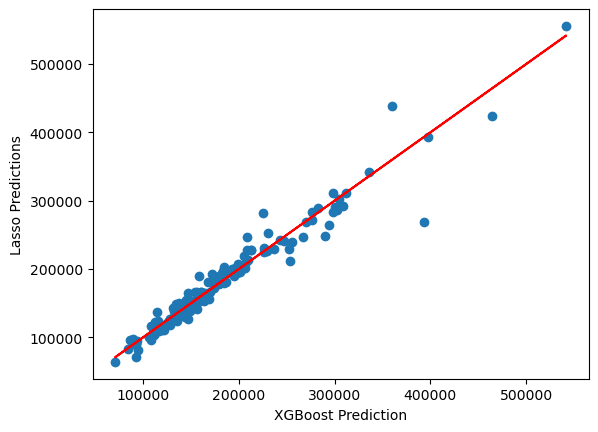

In [27]:
#Compare Predictions
import matplotlib.pyplot as plt

print(f'XGBoost: {round(Y_PREDICTED_XGBOOST.mean(),2)} +/- {round(Y_PREDICTED_XGBOOST.std(), 3)}')
print(f'LASSO: {round(Y_PREDICTED_LASSO.mean(),2)} +/- {round(Y_PREDICTED_LASSO.std(), 3)}')

print(f'Difference: {round(np.mean(Y_PREDICTED_XGBOOST - Y_PREDICTED_LASSO),2)} +/- {round(np.std(Y_PREDICTED_XGBOOST - Y_PREDICTED_LASSO),2)}')

plt.scatter(Y_PREDICTED_XGBOOST, Y_PREDICTED_LASSO)
plt.xlabel('XGBoost Prediction')
plt.ylabel('Lasso Predictions')
plt.plot(Y_PREDICTED_XGBOOST, Y_PREDICTED_XGBOOST, color='red')

In [16]:
#Choose XGBoost-Stack Model

Y_PREDICTED = pd.DataFrame(Y_PREDICTED_XGBOOST, columns=['SalePrice'])
Y_PREDICTED.index.name = 'Id'

Y_PREDICTED.to_csv('../Submitted Predictions - Karl-Henrik Lohmann.csv')